# The Nature Conservancy Fisheries Monitoring - EDA

In [1]:
import platform
import random
import torch
import torchvision
import fastai
from fastai.vision.all import *
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('fastai version:      {}'.format(fastai.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.7.10
torch version:       1.7.0
torchvision version: 0.8.1
fastai version:      2.3.0
pandas version:      1.2.3
numpy version:       1.19.5
matplotlib version:  3.4.1
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


In [2]:
seed = 0

data_dir = Path('./train')

## Load Data From Kaggle

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-nature-conservancy-fisheries-monitoring/train.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg2.7z
/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg1.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg2.csv.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg1.csv.zip


In [4]:
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/train.zip .
!unzip train.zip
!rm train/.DS_Store

Archive:  train.zip
   creating: train/
  inflating: train/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/train/
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/ALB/
  inflating: train/ALB/img_00003.jpg  
  inflating: train/ALB/img_00010.jpg  
  inflating: train/ALB/img_00012.jpg  
  inflating: train/ALB/img_00015.jpg  
  inflating: train/ALB/img_00019.jpg  
  inflating: train/ALB/img_00020.jpg  
  inflating: train/ALB/img_00029.jpg  
  inflating: train/ALB/img_00032.jpg  
  inflating: train/ALB/img_00037.jpg  
  inflating: train/ALB/img_00038.jpg  
  inflating: train/ALB/img_00039.jpg  
  inflating: train/ALB/img_00041.jpg  
  inflating: train/ALB/img_00043.jpg  
  inflating: train/ALB/img_00045.jpg  
  inflating: train/ALB/img_00055.jpg  
  inflating: train/ALB/img_00057.jpg  
  inflating: train/ALB/img_00074.jpg  
  inflating: train/ALB/img_00085.jpg  
  inflating: train/ALB/img_00090.jpg  
  inflating: train/ALB/img_00097.jpg  
  inflating: train/ALB/i

## EDA

In [5]:
# Print Sample Counts per Class
data = {}
for c in data_dir.iterdir():
    data[c.name] = len(list(c.iterdir()))
    
df = pd.DataFrame({
    'train': pd.Series(data=data)
})

df["train_pct"] = df["train"]/df["train"].sum()
df = df.sort_values(by=['train'], ascending=False)

print("Samples: {}".format(df['train'].sum())); df

Samples: 3777


,train,train_pct
ALB,1719,0.455123
YFT,734,0.194334
NoF,465,0.123114
OTHER,299,0.079163
BET,200,0.052952
SHARK,176,0.046598
DOL,117,0.030977
LAG,67,0.017739


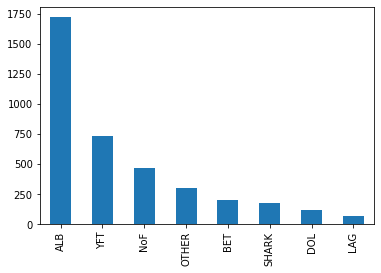

In [6]:
# Plot Sample Counts per Class
df['train'].plot.bar();

## Visualize Sample Images

In [7]:
# Load Data into Fastai DataLoader
set_seed(seed, reproducible=True)

db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()), 
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=Resize(224) # necessary because images are not all of the same size
)

dls = db.dataloaders(source=data_dir, bs=25, seed=seed)

print('Classes: {}'.format(dls.vocab)); print()
print('Train Samples: {}'.format(len(dls.train_ds)))
print('Valid Samples: {}'.format(len(dls.valid_ds)))
print('Total Samples: {}'.format(len(dls.train_ds) + len(dls.valid_ds)))

Classes: ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

Train Samples: 3022
Valid Samples: 755
Total Samples: 3777


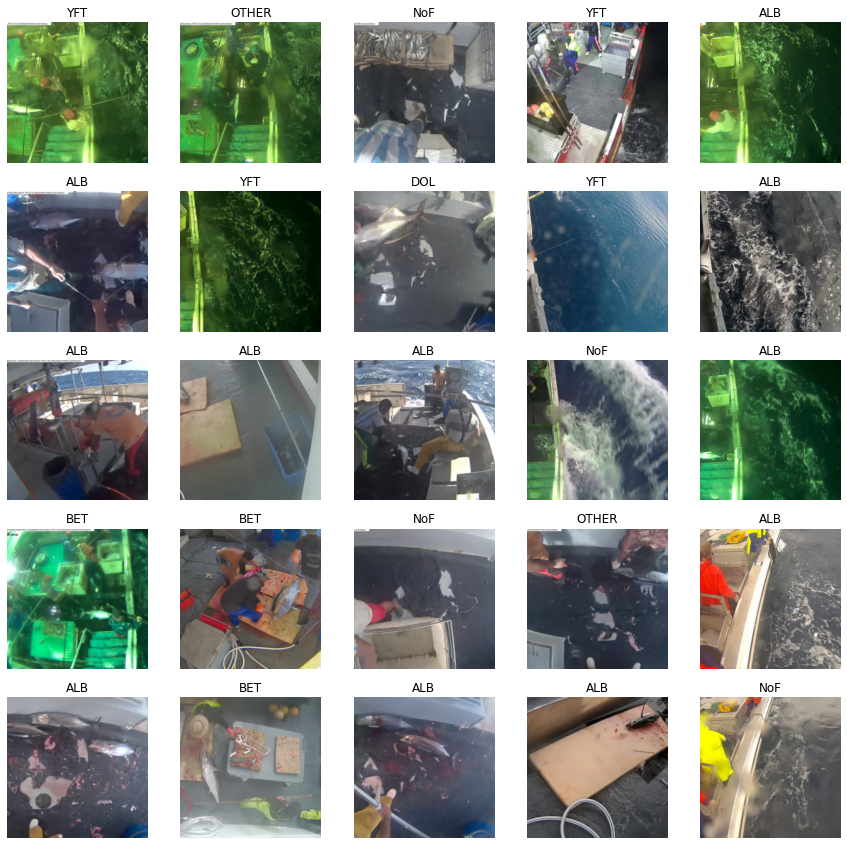

In [8]:
# Show a few Samples
dls.show_batch(max_n=25)